In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix, RocCurveDisplay

import xgboost as xgb

import matplotlib.pyplot as plt
import seaborn as sn
from matplotlib.patches import Patch
import numpy as np

from datetime import datetime

timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')


/home/juanjosebuitrago/.local/lib/python3.9/site-packages/pkg_resources/__init__.py:116: PkgResourcesDeprecationWarning: 0.1.39ubuntu1 is an invalid version and will not be supported in a future release
  warnings.warn(
/home/juanjosebuitrago/.local/lib/python3.9/site-packages/pkg_resources/__init__.py:116: PkgResourcesDeprecationWarning: 2.2.1pop0-1628521831-21.10-5dbe6cf is an invalid version and will not be supported in a future release
  warnings.warn(


In [2]:
def load_data(file_path):
    # Read the csv and dummify the categorical variables
    df = pd.read_csv(file_path)
    df["customer_gender"] = df["customer_gender"].replace(1, 0).replace(2, 1)
    df["customer_education"] = df["customer_education"].fillna(0)
    df = pd.get_dummies(df, columns=["customer_relationship"], drop_first=True)
    return df
    

Function to process DFs

In [3]:
def process_df(df, cols=[]):
    df = pd.get_dummies(df, columns=["customer_children"], drop_first=True)
    df = pd.get_dummies(df, columns=["customer_education"], drop_first=True)

    # Dropping irrelevant variables
    df = df.drop(["customer_postal_code", "customer_since_all", "customer_since_bank", "customer_occupation_code",
                  "customer_birth_date", "bal_savings_account_starter", "bal_current_account_starter", "has_life_insurance_decreasing_cap",
                  "has_mortgage_loan"], axis=1)

    df = df.drop(cols, axis=1)
    return df


Lets do some EDA and feature selection

In [4]:
# Read the csv and dummify the categorical variables
df = load_data("data/train_month_3_with_target.csv")

Figure out which variables are useful

In [5]:
dummy_variables = ["homebanking_active", "has_homebanking", "has_insurance_21", "has_insurance_23",
                   "has_life_insurance_fixed_cap", "has_life_insurance_decreasing_cap", "has_fire_car_other_insurance",
                   "has_personal_loan", "has_mortgage_loan", "has_current_account", "has_pension_saving", "has_savings_account",
                   "has_savings_account_starter", "has_current_account_starter", "customer_self_employed", "customer_gender", "customer_relationship_single"]

num_variables = ["bal_insurance_21", "bal_insurance_23", "cap_life_insurance_fixed_cap", "cap_life_insurance_decreasing_cap", "prem_fire_car_other_insurance",
                 "bal_personal_loan", "bal_mortgage_loan", "bal_current_account", "bal_pension_saving", "bal_savings_account", "bal_savings_account_starter", "bal_current_account_starter"]

drop_columns = []

In [246]:
y = df[["target"]]
n_cases = np.sum(y["target"])

df_booleans = pd.DataFrame(columns=["columns", "cases", "proportion"])

for ix, col in enumerate(dummy_variables):
    positives = confusion_matrix(df["target"], df[col])[1, 1]
    df_booleans = df_booleans.append(pd.DataFrame({"columns": [col], "cases": [positives],
                                                   "proportion": [positives/n_cases]}))
    if positives/n_cases < .2:
        drop_columns.append(col)


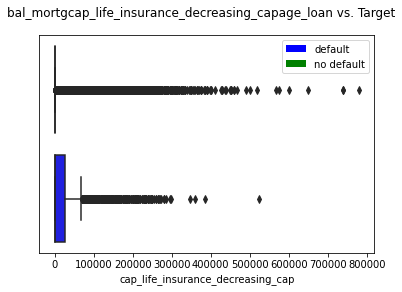

In [165]:
# Boxplot of the balance in savings account
fig, ax = plt.subplots()

sn.boxplot(x="cap_life_insurance_decreasing_cap", y="target",
           data=df, orient="h", palette={1: "blue", 0: "green"}, ax=ax)

ax.get_yaxis().set_visible(False)

fig.suptitle("bal_mortgcap_life_insurance_decreasing_capage_loan vs. Target")

color_patches = [
    Patch(facecolor="blue", label="default"),
    Patch(facecolor="green", label="no default")
]
ax.legend(handles=color_patches)


Load data from the previous months

In [6]:
df_2 = pd.read_csv("data/train_month_2.csv")
df_1 = pd.read_csv("data/train_month_1.csv")

df_1["target"] = df["target"]
df_2["target"] = df["target"]

df["bal_diff_2"] = df["bal_savings_account"] - df_2["bal_savings_account"]
df["bal_curr_2"] = df["bal_current_account"] - df_2["bal_current_account"]
# df["bal_diff_1"] = df["bal_savings_account"] - df_1["bal_savings_account"]


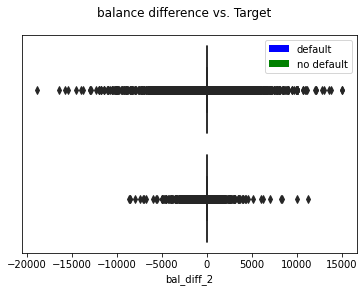

In [168]:
fig, ax = plt.subplots()

sn.boxplot(x="bal_diff_2", y="target", data=df, orient="h",
           palette={1: "blue", 0: "green"}, ax=ax)

ax.get_yaxis().set_visible(False)

fig.suptitle("balance difference vs. Target")

color_patches = [
    Patch(facecolor="blue", label="default"),
    Patch(facecolor="green", label="no default")
]
ax.legend(handles=color_patches)


load, process and split the DF

In [7]:
best_cols = []

y = df[["target"]]

# for col in df.columns:
#     # print(col)
#     try:
#         corr = np.corrcoef(df[col], df["target"])[1, 0]
#         # print(col, np.abs(corr))
#         if np.abs(corr) > 0.08:
#             best_cols.append(col)
#     except:
#         pass

# # best_cols = []
df = process_df(df, drop_columns)

X = df.drop(["target", "client_id"], axis = 1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33)

churn_cases = np.sum(y["target"])
n_cases = len(y)


In [8]:
print(f"There are {churn_cases} churn cases in {n_cases}. This means that {round(churn_cases/n_cases,5)} are positive cases")


There are 1913 churn cases in 63697. This means that 0.03003 are positive cases


Youtube tutorial classifier

In [9]:
model = DecisionTreeClassifier(criterion="entropy", max_depth=1)
AdaBoost = AdaBoostClassifier(base_estimator=model, n_estimators=400, learning_rate=1)
boostmodel = AdaBoost.fit(X_train, y_train)

/home/juanjosebuitrago/.local/lib/python3.9/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Train XGB classifier

In [10]:
xgbc = xgb.XGBClassifier(random_state=42)
xgbc.fit(X_train, y_train)


/home/juanjosebuitrago/.local/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/juanjosebuitrago/.local/lib/python3.9/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/juanjosebuitrago/.local/lib/python3.9/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel(

[13:00:37] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=12,
              num_parallel_tree=1, predictor='auto', random_state=42,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

Train a Random Forest Classifier

In [11]:
rfc = RandomForestClassifier(n_estimators=10, random_state=42)
rfc.fit(X_train, y_train)


/tmp/ipykernel_90786/3368703514.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rfc.fit(X_train, y_train)


RandomForestClassifier(n_estimators=10, random_state=42)

Compare ROC curves for train set

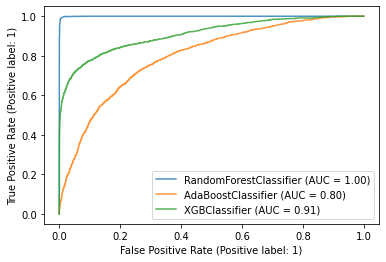

In [12]:
ax = plt.gca()
rfc_disp = RocCurveDisplay.from_estimator(
    rfc, X_train, y_train, ax=ax, alpha=0.8)
boost_disp = RocCurveDisplay.from_estimator(
    boostmodel, X_train, y_train, ax=ax, alpha=0.8)
xgbc_disp = RocCurveDisplay.from_estimator(
    xgbc, X_train, y_train, ax=ax, alpha=0.8)
plt.show()


Compare ROC curves for test set

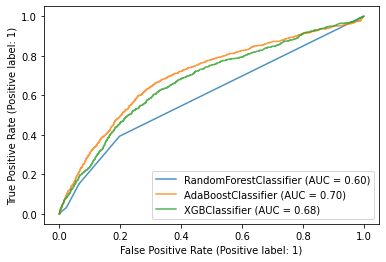

In [13]:
ax = plt.gca()
rfc_disp = RocCurveDisplay.from_estimator(
    rfc, X_test, y_test, ax=ax, alpha=0.8)
boost_disp = RocCurveDisplay.from_estimator(
    boostmodel, X_test, y_test, ax=ax, alpha=0.8)
xgbc_disp = RocCurveDisplay.from_estimator(
    xgbc, X_test, y_test, ax=ax, alpha=0.8)
plt.show()


In [14]:
cm_boost = confusion_matrix(y_train, boostmodel.predict(X_train))
cm_rfc = confusion_matrix(y_train, rfc.predict(X_train))
cm_xgbc = confusion_matrix(y_train, xgbc.predict(X_train))
cm_boost, cm_rfc, cm_xgbc


(array([[41407,     8],
        [ 1234,    27]]),
 array([[41409,     6],
        [  323,   938]]),
 array([[41415,     0],
        [ 1003,   258]]))

Confussion matrices for test DFs

In [15]:
cm_boost = confusion_matrix(y_test, boostmodel.predict(X_test))
cm_rfc = confusion_matrix(y_test, rfc.predict(X_test))
cm_xgbc = confusion_matrix(y_test, xgbc.predict(X_test))
cm_boost, cm_rfc, cm_xgbc


(array([[20352,    17],
        [  652,     0]]),
 array([[20331,    38],
        [  652,     0]]),
 array([[20356,    13],
        [  649,     3]]))

Predict a probability and export the result

In [16]:
new_df = load_data("data/test_month_3.csv")

df_pred = pd.DataFrame()
df_pred["ID"] = new_df["client_id"]

new_df_2 = pd.read_csv("data/test_month_2.csv")
new_df["bal_diff_2"] = new_df["bal_savings_account"] - new_df_2["bal_savings_account"]

new_df["bal_curr_2"] = new_df["bal_current_account"] - new_df["bal_current_account"]

new_df = process_df(new_df, drop_columns)

try:
    x_val = new_df.drop(["client_id"], axis=1)
except:
    pass

predict_proba = xgbc.predict_proba(x_val)
df_pred["PROB"] = predict_proba[:, 1]

df_pred.to_csv(f"{timestamp}_attempt.csv", index=None)


In [179]:
# tyyrhgfg
